# Imports
---

In [1]:
from scipy.io import loadmat
from scipy.signal import welch, butter, lfilter
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided
import itertools
from matplotlib.patches import Patch
%matplotlib inline

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import numpy as np

# Import Data
---

In [146]:
data = loadmat('../p3_subjectData.mat')
fs = data['subjectData'][0,0][0][0,0][1][0,0][0][0,0]
sensors = np.concatenate(data['subjectData'][0,0][0][0,0][1][0,0][1][:,0])
trialTypes = ['Flx','Ext','Rst']

In [156]:
def generateData(period,run):
    subject = data['subjectData'][0,0]
    p = subject[period]
    r = p[0,run]
    header = r[1][0,0]
    assert(np.array_equal(sensors,np.concatenate(header[1][:,0])))
    assert(fs==header[0][0,0])
    timestamps = header[2][0,0][1]
    return r[0][timestamps[0,0]:timestamps[-1,0]], header[2][0,0][0][3:-1:5,0]//100-1, timestamps[1:-1].reshape(-1,5)

def filterTrials(period,run,motion):
    eeg, motions, timestamps = generateData(period,run)
    return eeg, timestamps[motions==motion]

In [157]:
eeg, motions, timestamps = generateData(0,0)

In [11]:
def load(name):
    return loadmat(f'../{name}.mat')[name]

In [13]:
sub1.shape

(3085, 32, 75)

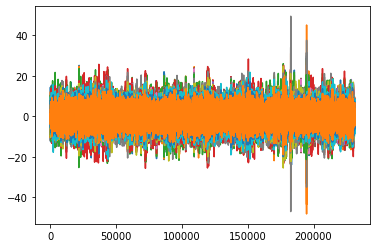

In [14]:
for i in sub1.transpose((1,2,0)).reshape(32,-1):
    plt.plot(i)

# Prepare Signals
---

# Feature Extraction
---

In [124]:
def rolling_window(a, window, overlap):
    shape = (int((a.shape[0] - overlap)/(window-overlap)), window) + a.shape[1:]
    strides = (a.strides[0]*(window-overlap),)+a.strides
    return as_strided(a, shape=shape, strides=strides)
def mav(eeg):
    return rolling_window(np.abs(eeg), window, overlap).mean(axis=1)

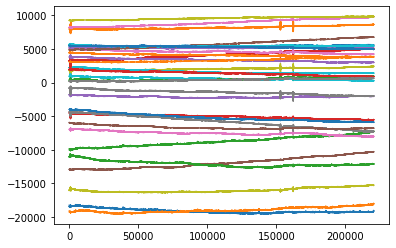

In [168]:
for i in range(32):
    plt.plot(eeg[:,i])

In [167]:
eeg.shape

(220411, 32)

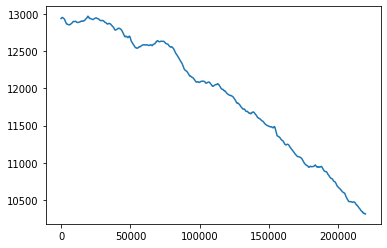

In [163]:
plt.plot(mav[:,5])

In [16]:
def mavgraphs(data,name):
    index = -1
    mavfig,mavax = plt.subplots(3,3,figsize=(30,7))
    varfig,varax = plt.subplots(3,3,figsize=(30,7))
    mavax = mavax.flatten()
    varax = varax.flatten()
    for window in (np.array([.05,.1,.3])*fs).astype(int):
        for overlap in (np.array([0,.25,.75])*window).astype(int):
            index+=1
            y = rolling_window(data,window,overlap)
            mav = np.abs(y).mean(axis=1)
            var = y.var(axis=1)
            
            mavax[index].plot(mav,label=f'overlap: {overlap}')
            varax[index].plot(var,label=f'overlap: {overlap}')
            
            ''' triggers = np.argwhere(np.diff(labels)>0).flatten()
            colors = itertools.cycle(['g','r'])
            for line in triggers:
                color=next(colors)
                mavax[index].axvline(line,color=color)
                varax[index].axvline(line,color=color)'''
    
    mavfig.suptitle(f'{name} MAV', fontweight='bold')
    varfig.suptitle(f'{name} VAR', fontweight='bold')
    mavax[3].set_ylabel('window\nsize', labelpad=40, rotation=0, size='large', fontweight='bold')
    mavax[7].set_xlabel('overlap', size='large',fontweight='bold')
    varax[3].set_ylabel('window\nsize', labelpad=40, rotation=0, size='large', fontweight='bold')
    varax[7].set_xlabel('overlap', size='large', fontweight='bold')
    mavfig.tight_layout()
    varfig.tight_layout()

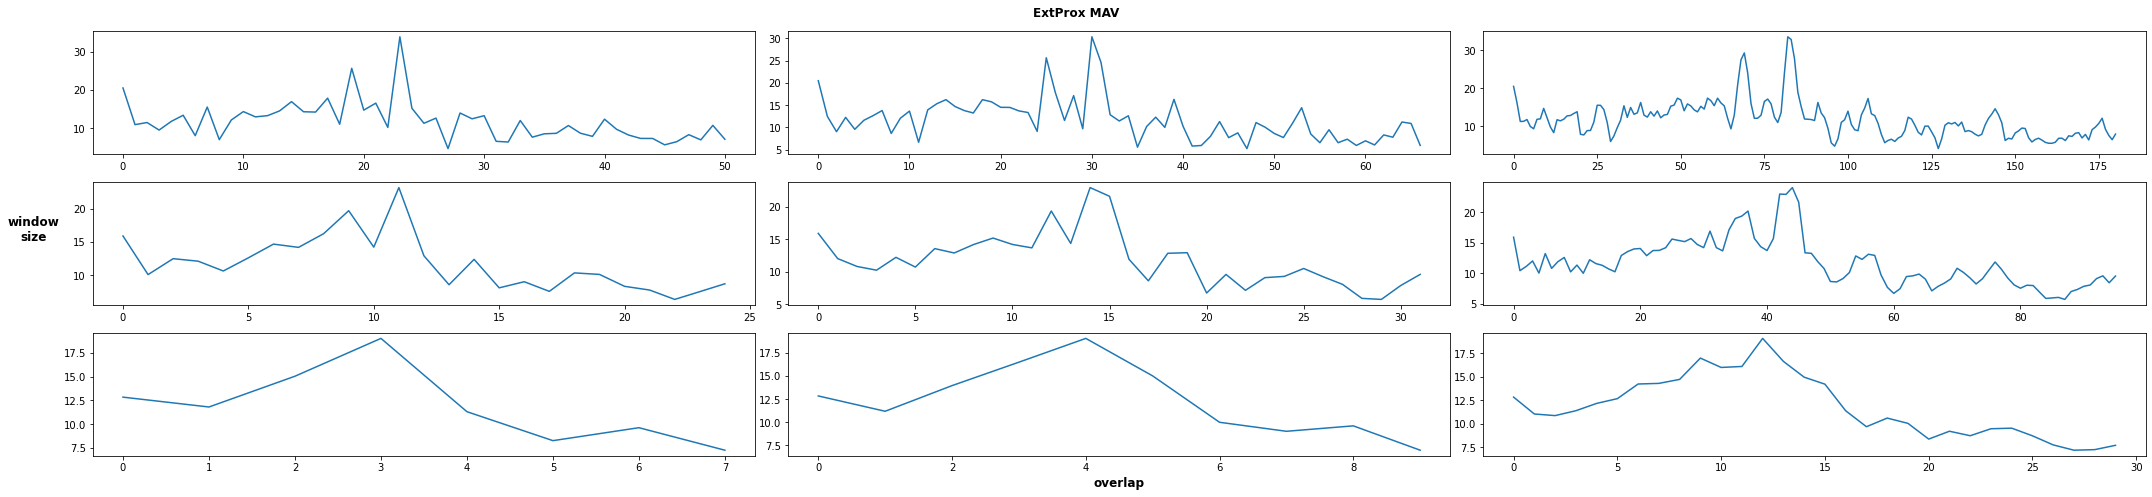

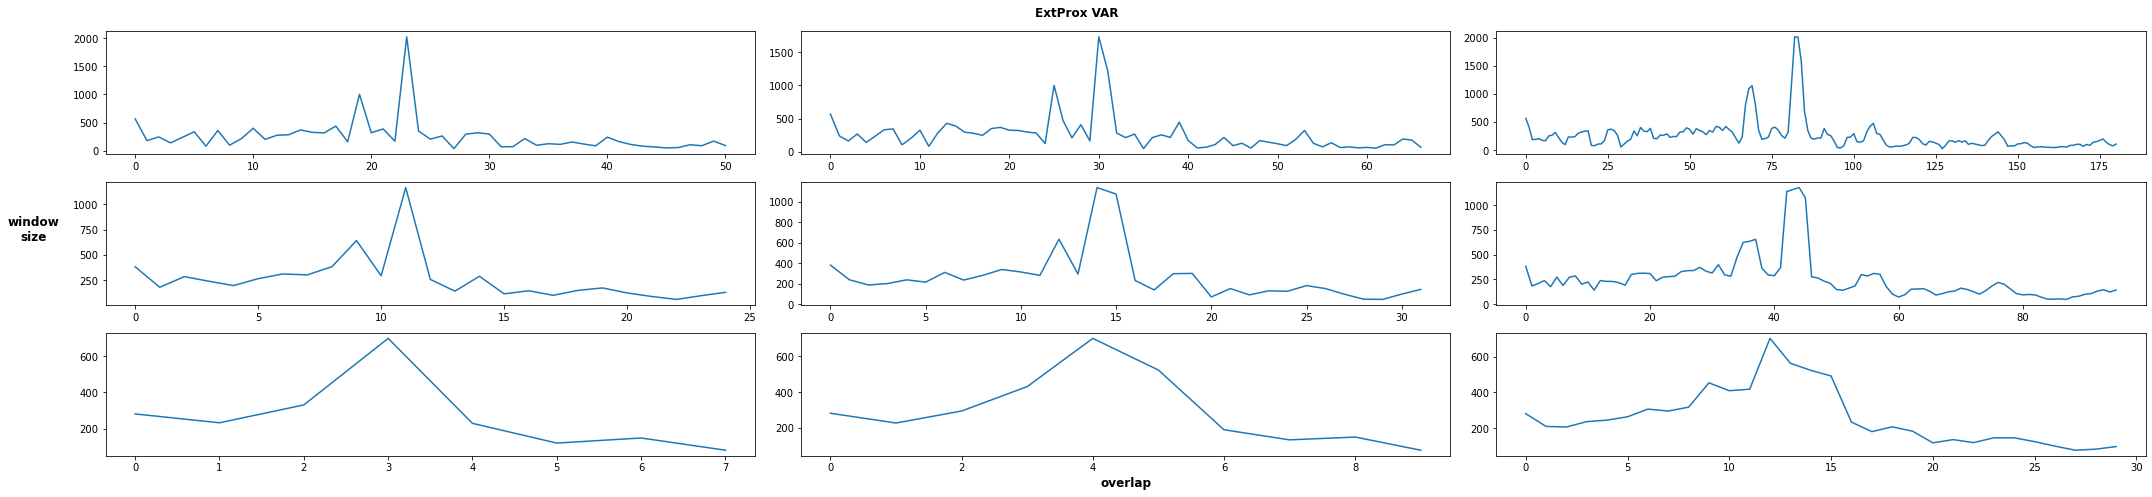

In [17]:
mavgraphs(active[0][0],sensors[0])

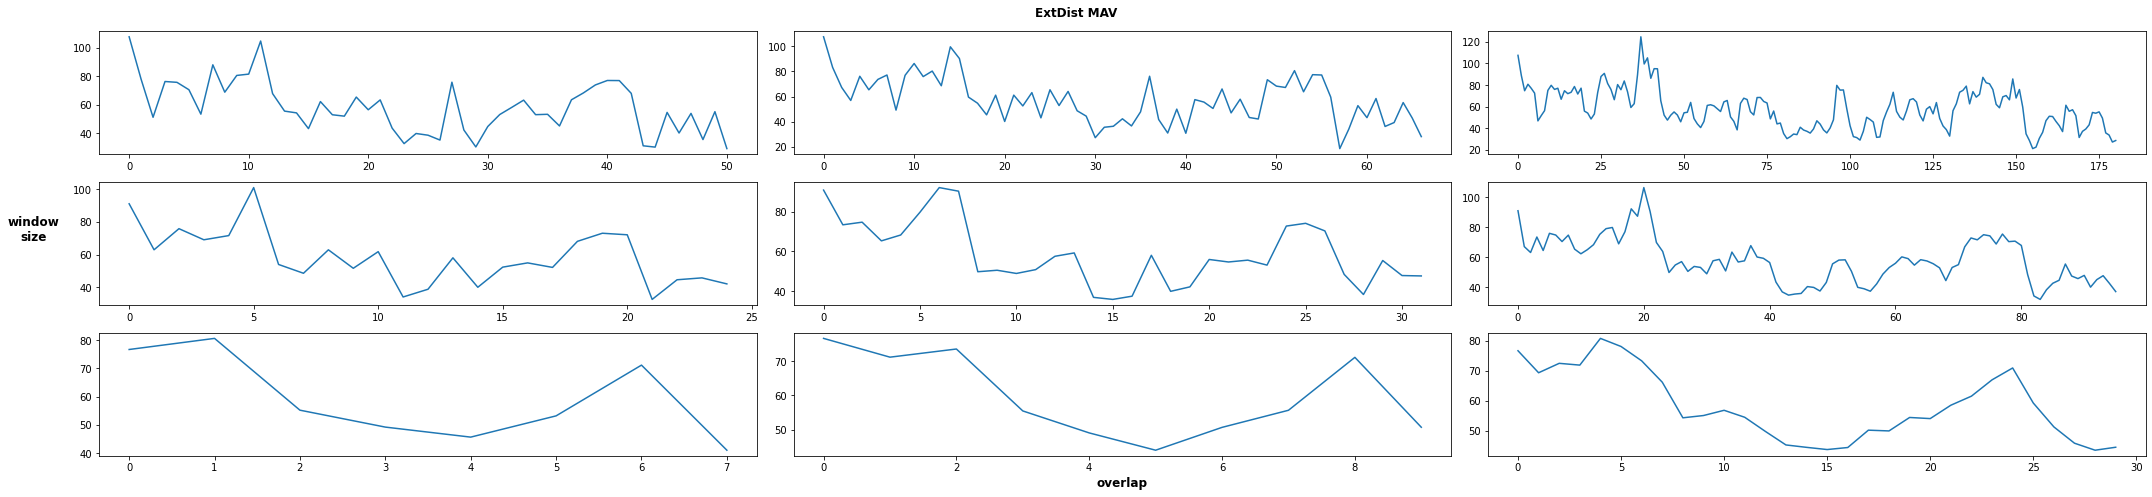

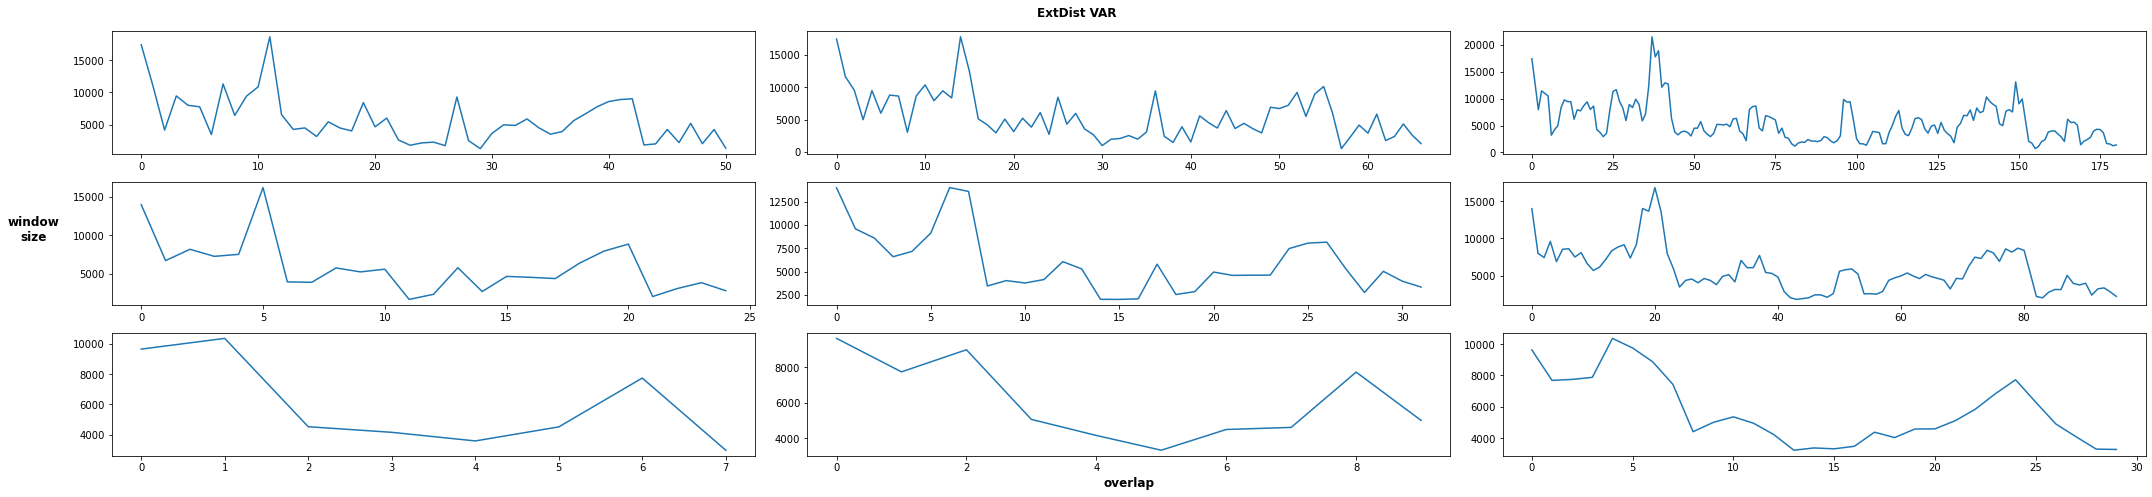

In [18]:
mavgraphs(active[0][1],sensors[1])

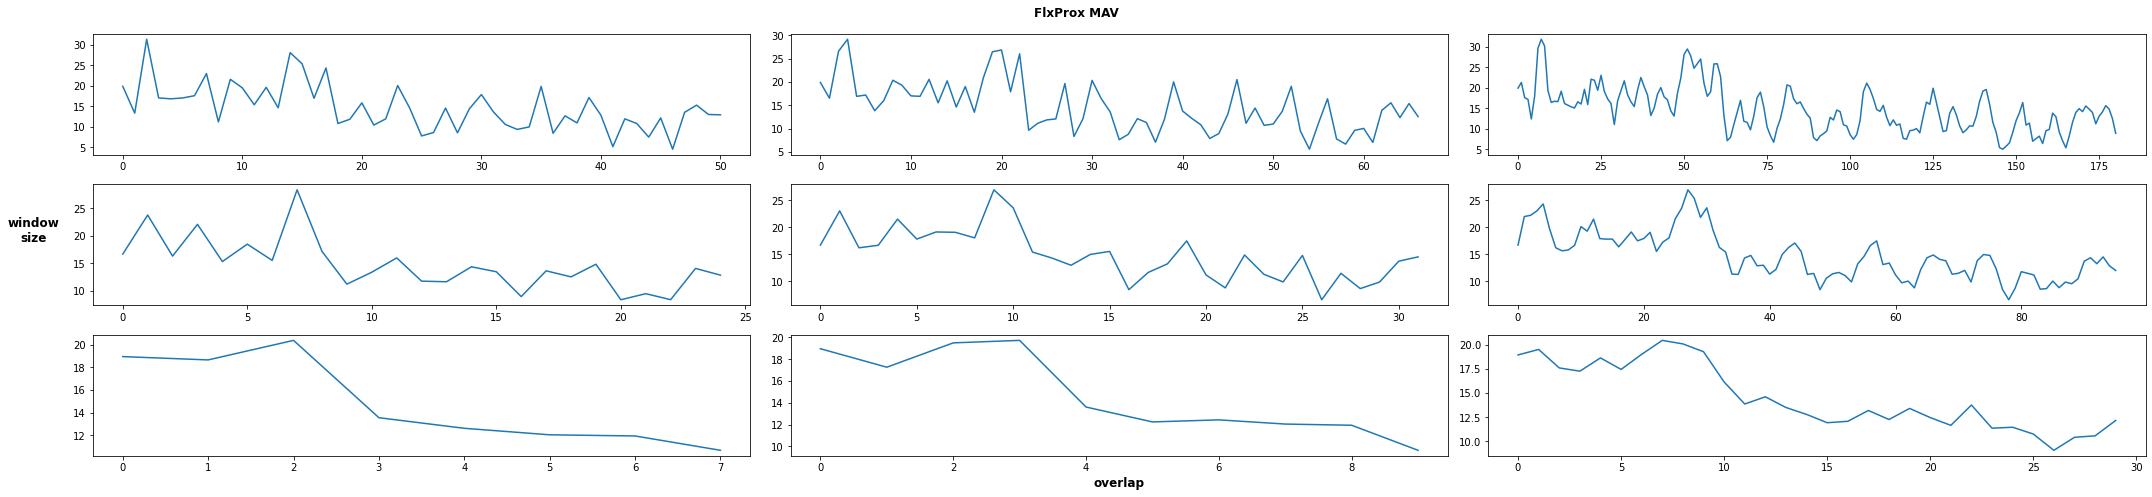

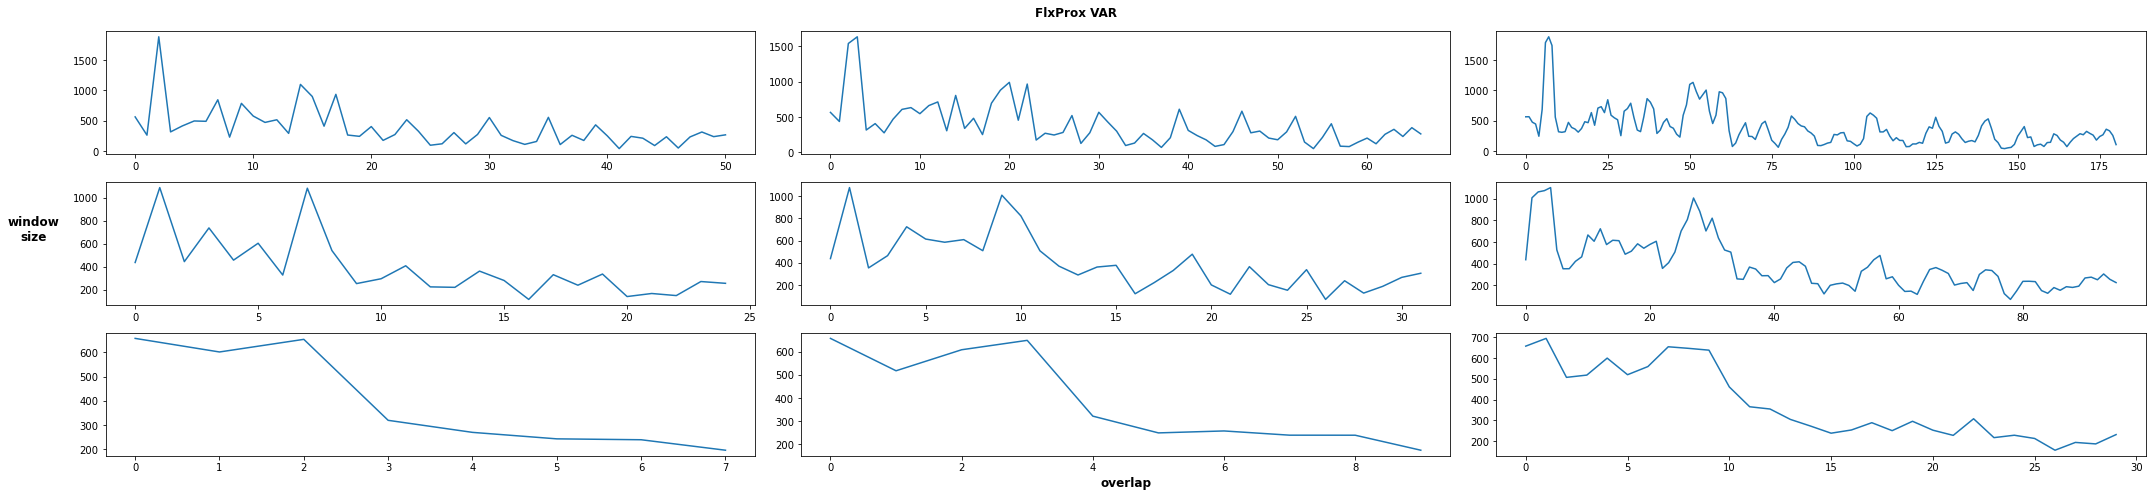

In [19]:
mavgraphs(active[0][2],sensors[2])

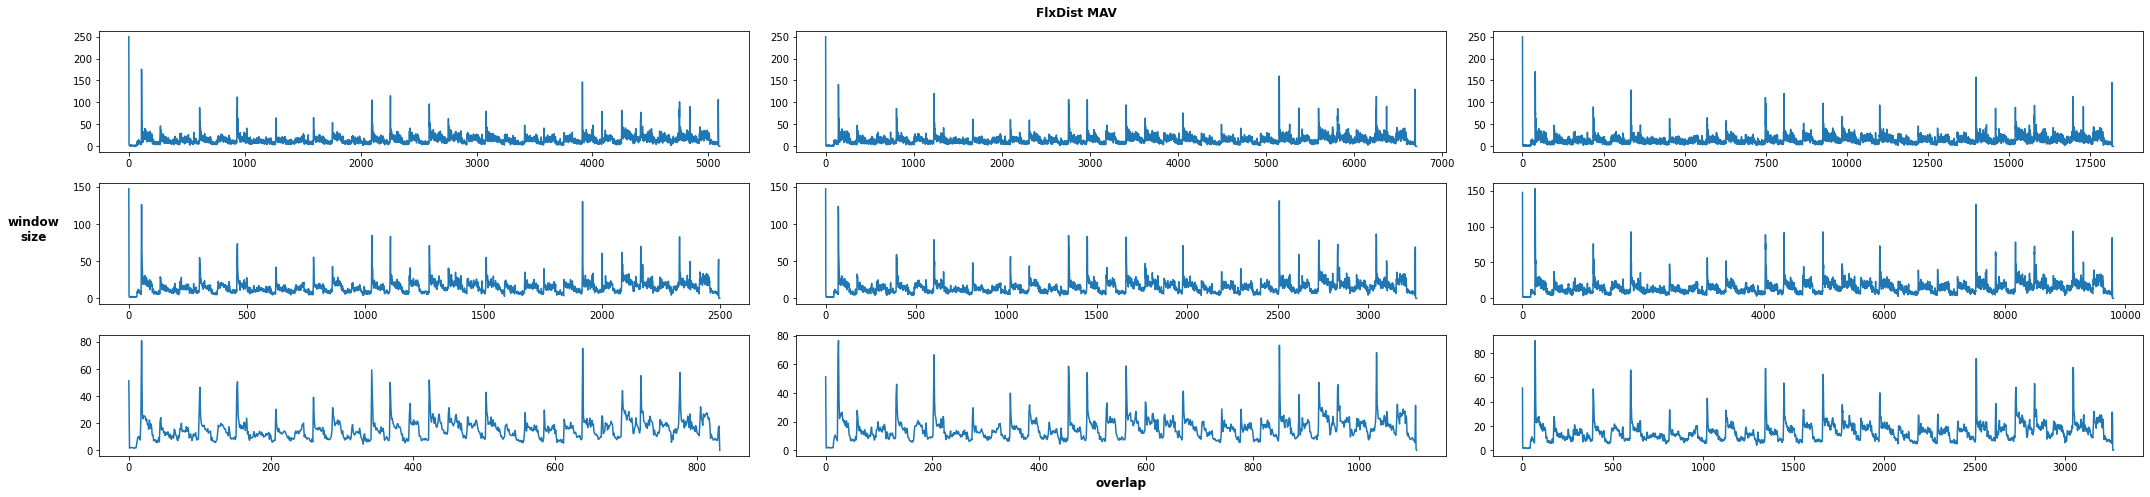

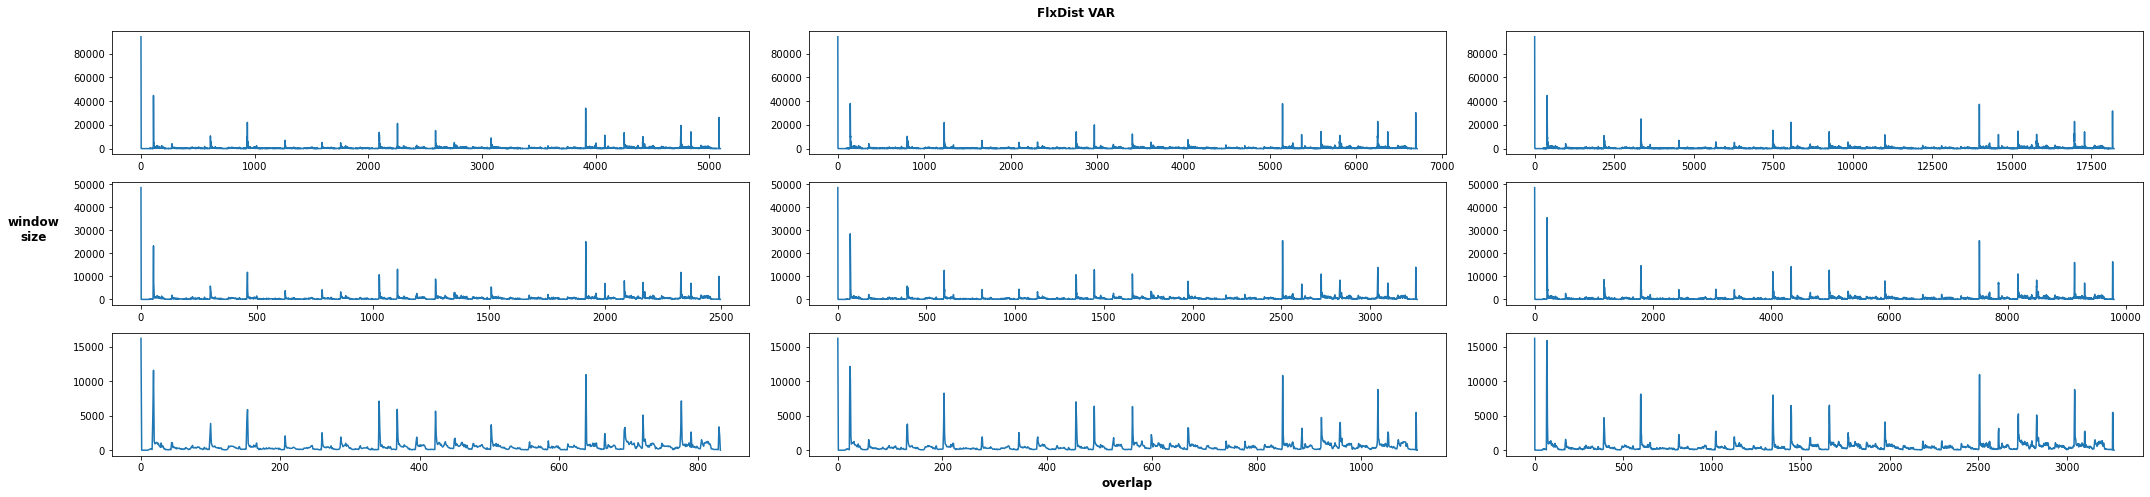

In [20]:
mavgraphs(filtered[0][3],sensors[3])

## 2.2.1 MAV choice
Choosing larger window to reduce variation among trial data, and choosing large overlap to increase the amount of data.

# Average Mav Pattern
---

# Classification and Cross Validation
Using run-wise cross-validation works better since there may be changes in the placement of electrodes and other confounding factors that a model should be able to generalize against. 
Additionally each run is sequential and this could be used by models that exploit time dependence between samples.

---

In [25]:
def confuseplot(title,mat,ax):
    ax.set_title(title)
    ax.tick_params(left=False, bottom=False)
    sn.heatmap(mat, ax=ax, xticklabels=trialTypes, yticklabels=trialTypes, annot=True, annot_kws={"size": 16},cmap='Blues', fmt='g')

In [26]:
def score(xtrain, ytrain,xtest,ytest,ax):
    clf = LinearDiscriminantAnalysis()
    scores = cross_val_score(clf, xtrain, ytrain, cv=5)
    print(f'LDA train score: {scores.mean()}')
    clf.fit(xtrain,ytrain)
    confuseplot("Subject's LDA",confusion_matrix(clf.predict(xtest), ytest),ax[0])
    clf2 = QuadraticDiscriminantAnalysis()
    scores = cross_val_score(clf2, xtrain, ytrain, cv=5)
    print(f'QDA train score: {scores.mean()}')
    clf2.fit(xtrain,ytrain)
    confuseplot("Subject's QDA",confusion_matrix(clf2.predict(xtest), ytest),ax[1])
    return clf, clf2

## Subject 1
Neither LDA nor QDA could seperate Grasp motions from the others. This makes sense since grasp tended to require a much more complex set of muscle activity across multiple fingers.

LDA train score: 0.7636111111111112
QDA train score: 0.7172222222222222


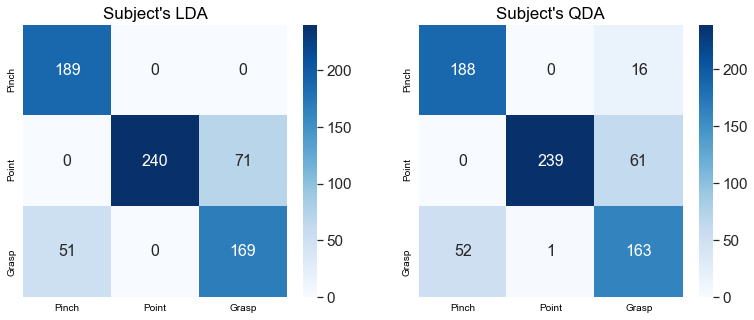

In [27]:
trialsamples = tfeatures.shape[-1]
xtrain = tfeatures[:,:,:5*trialsperrun,:].reshape((tfeatures.shape[0]*tfeatures.shape[1],-1)).T
xtest = tfeatures[:,:,5*trialsperrun:6*trialsperrun,:].reshape((tfeatures.shape[0]*tfeatures.shape[1],-1)).T
ytrain = triallabels[:5*trialsperrun].repeat(tfeatures.shape[-1])
ytest = triallabels[5*trialsperrun:6*trialsperrun].repeat(tfeatures.shape[-1])


fig,ax = plt.subplots(1,2,figsize = (13,5))
sn.set(font_scale=1.4)
l1,q1 = score(xtrain,ytrain,xtest,ytest,ax)

## Subject 2
LDA was quite effective at describing Subject 2's motions. Its likely that his motions were more consistant.

LDA train score: 0.9494444444444445
QDA train score: 0.9041666666666666


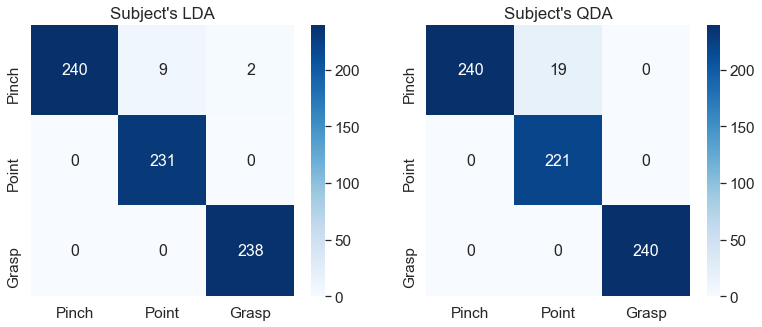

In [28]:
trialsamples = tfeatures.shape[-1]
subjectoffset = tfeatures.shape[2]//2
xtrain2 = tfeatures[:,:,subjectoffset:subjectoffset+5*trialsperrun,:].reshape((tfeatures.shape[0]*tfeatures.shape[1],-1)).T
xtest2 = tfeatures[:,:,subjectoffset+5*trialsperrun:subjectoffset+6*trialsperrun,:].reshape((tfeatures.shape[0]*tfeatures.shape[1],-1)).T
ytrain2 = triallabels[subjectoffset:subjectoffset+5*trialsperrun].repeat(tfeatures.shape[-1])
ytest2 = triallabels[subjectoffset+5*trialsperrun:subjectoffset+6*trialsperrun].repeat(tfeatures.shape[-1])


fig,ax = plt.subplots(1,2,figsize = (13,5))
sn.set(font_scale=1.4)
l2, q2 = score(xtrain2,ytrain2,xtest2,ytest2,ax)

## Transfer
Neither model was able to generalize across subjects. This probably means that both subjects used their muscles slightly differently when perforing actions.

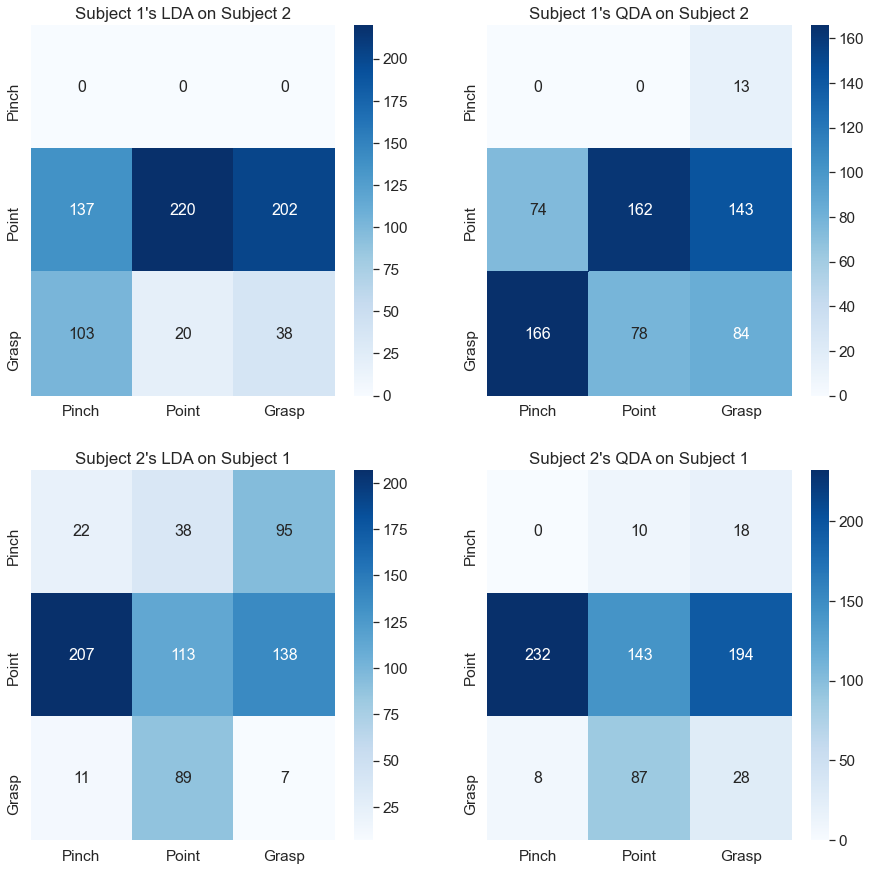

In [29]:
fig,ax = plt.subplots(2,2,figsize = (15,15))
sn.set(font_scale=1.4)
confuseplot("Subject 1's LDA on Subject 2",confusion_matrix(l1.predict(xtest2), ytest2),ax[0,0])
confuseplot("Subject 1's QDA on Subject 2",confusion_matrix(q1.predict(xtest2), ytest2),ax[0,1])
confuseplot("Subject 2's LDA on Subject 1",confusion_matrix(l2.predict(xtest), ytest),ax[1,0])
confuseplot("Subject 2's QDA on Subject 1",confusion_matrix(q2.predict(xtest), ytest),ax[1,1])
plt.show()